Este nobook lo usamos para sacar los datos de los recorridos que (por desgracia) se tienen que sacar a mano.

Cosas que pongo aquí porque si no se me olvidan:

* Los carriles se enumeran desde 0 (el derecho) hasta n (el más izquiero de todos). Eso quiere decir que los cambios son -1 a la derecha y +1 a la izquierda.

In [6]:
%matplotlib notebook

import os

import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pynsia.pointcloud import PointCloud
from sklearn.cluster import DBSCAN

import ipywidgets as widgets
from IPython.display import display

In [7]:
pitch = -40.5
roll = -3.5
yaw = 0

α = pitch * np.pi / 180.
φ = roll * np.pi / 180.
ϑ = yaw * np.pi / 180.

sin_α, cos_α = np.sin(α), np.cos(α)
sin_φ, cos_φ = np.sin(φ), np.cos(φ)
sin_ϑ, cos_ϑ = np.sin(ϑ), np.cos(ϑ)

a = cos_φ * cos_ϑ - sin_φ * sin_α * sin_ϑ
b = sin_ϑ * cos_φ + cos_ϑ * sin_α * sin_φ
c = -sin_φ * cos_α
d = -sin_ϑ * cos_α
e = cos_α * cos_ϑ
f = sin_α
g = cos_ϑ * sin_φ + sin_ϑ * sin_α * cos_φ
h = sin_ϑ * sin_φ - cos_ϑ * sin_α * cos_φ
i = cos_α * cos_φ

transformation_matrix = np.array([
    [a, b, c, 0],
    [d, e, f, 0],
    [g, h, i, 0],
    [
        0 * a + 0 * d + 1.75 * g,
        0 * b + 0 * e + 1.75 * h,
        0 * c + 0 * f + 1.75 * i,
        1
    ],
])

In [40]:
BASE_PATH = '/home/blazaid/Projects/data-phd/sync'
SUBJECT = 'miguel'  # edgar, jj, miguel
DATASET = 'training'  # training, validation

LIDAR_CALIBRATION = transformation_matrix
print(LIDAR_CALIBRATION)

[[ 9.98489097e-01  4.79524696e-04 -5.49480876e-02  0.00000000e+00]
 [-0.00000000e+00  9.99961923e-01  8.72653550e-03  0.00000000e+00]
 [ 5.49501799e-02 -8.71335055e-03  9.98451078e-01  0.00000000e+00]
 [ 9.61628148e-02 -1.52483635e-02  1.74728939e+00  1.00000000e+00]]


In [41]:
PATH = os.path.join(BASE_PATH, SUBJECT, DATASET)
df = pd.read_csv(os.path.join(PATH, 'dataset.csv'))

<IPython.core.display.Javascript object>


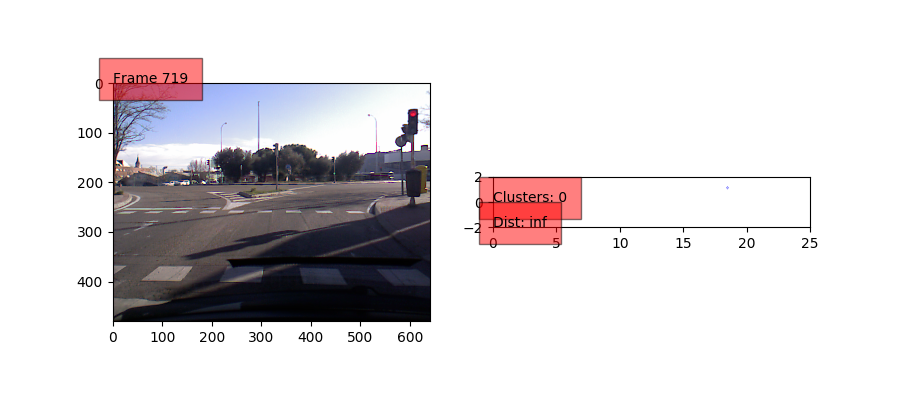

KeyboardInterrupt: 

In [43]:
pitch = 3.15
roll = 0.5
yaw = 0

α = roll * np.pi / 180.
φ = pitch * np.pi / 180.
ϑ = yaw * np.pi / 180.

sin_α, cos_α = np.sin(α), np.cos(α)
sin_φ, cos_φ = np.sin(φ), np.cos(φ)
sin_ϑ, cos_ϑ = np.sin(ϑ), np.cos(ϑ)

a = cos_φ * cos_ϑ - sin_φ * sin_α * sin_ϑ
b = sin_ϑ * cos_φ + cos_ϑ * sin_α * sin_φ
c = -sin_φ * cos_α
d = -sin_ϑ * cos_α
e = cos_α * cos_ϑ
f = sin_α
g = cos_ϑ * sin_φ + sin_ϑ * sin_α * cos_φ
h = sin_ϑ * sin_φ - cos_ϑ * sin_α * cos_φ
i = cos_α * cos_φ

transformation_matrix = np.array([
    [a, b, c, 0],
    [d, e, f, 0],
    [g, h, i, 0],
    [
        0 * a + 0 * d + 1.75 * g,
        0 * b + 0 * e + 1.75 * h,
        0 * c + 0 * f + 1.75 * i,
        1
    ],
])

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

from_index = 100

def plt_image(ax, index, path):
    image = mpimg.imread(path)
    ax.clear()
    ax.imshow(image)
    ax.text(0, 0, 'Frame ' + str(index), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

def plt_lidar(ax, path):
    pc = PointCloud.load(path)
    ax.clear()
    ax.set_xlim((0, 25))
    ax.set_ylim((-2, 2))
    ax.set_aspect('equal', adjustable='box')
    points = np.concatenate([np.array([pc.points[:,0]]).T, pc.points[:,1:]], axis=1) 
    points = np.concatenate([points, np.ones((len(pc.points),1))], axis=1) 
    points = np.matmul(points, transformation_matrix)
    mask = (points[:,2] > 0.5) & \
           (points[:,2] < 2) & \
           (points[:,0] < 25) & \
           (points[:,0] > 0.35) & \
           (points[:,1] < 1.5) & \
           (points[:,1] > -1.5)
    points = points[mask,:2]
    # Look for clusters
    n_clusters = 0
    n_points = len(points)
    dist = np.inf
    if len(points) > 0:
        db = DBSCAN(eps=1.5, min_samples=5).fit(points)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        for cluster in range(n_clusters):
            obs = points[labels == cluster]
            dist = min(dist, np.sqrt(np.mean(obs[:, 0])**2 + np.mean(obs[:, 1])**2))

    
    ax.scatter(points[:,0], points[:,1], s=.01, c='b');
    ax.text(0, 0, 'Clusters: ' + str(n_clusters), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    ax.text(0, -2, 'Dist: ' + str(dist), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

for index, row in df.iterrows():
    if from_index is not None and from_index <= index:
        if not (pd.isnull(row['snapshots_path']) or pd.isnull(row['pointclouds_path'])):
            plt_image(axs[0], index, os.path.join(PATH, row['snapshots_path']))
            plt_lidar(axs[1], os.path.join(PATH, row['pointclouds_path']))
        
        fig.canvas.draw()

In [ ]:
sequences = {
    'edgar': {
        'training': [
            (100, 250),(400, 500),(510, 570),(800, 960),(1100, 1225),
            (1960, 2010),(2060, 2110),(2180, 2270),(2360, 2600),(2765, 2950),
            (3280, 3670),(4070, 4130),(4160, 4310),(4420, 4570),(4700, 4800),
            (4860, 4940),(5000, 5080),(5695, 5800),(5880, 5960),(6180, 6200),
            (6650, 6740),(6830, 6880),(6995, 7060),(7140, 7300),(7330, 7500),
            (7520, 7560),(7620, 7690),(7760, 7900),(7920, 7980),(8120, 8220),
            (8310, 8410),(8800, 8900),(9020, 9460),(9500, 9580),
        ],
        'validation': [
            (0, 80),(110, 300),(350, 540),(720, 820),(850, 900),(1440, 1670),
            (1900, 1980),(2500, 2730),(3030, 3160),(3270, 3380),(3550, 3690),
            (3890, 3910),(3960, 4000),(4080, 4440),
        ],
    },
    'jj': {
        'training': [
            (0, 100),(150 255),(950, 1110),(1111, 1300),(1520, 1660),
            (1700, 1860),(1900, 2020),(2160, 2250),(2430, 2550),(2551, 2695),
            (2900, 3080),(3160, 3250),(3260, 3340),(3660, 3705),(3860, 4200),
            (4710, 4780),(4836, 5200),(5310, 5610),(5890, 6050),(6420, 6540),
            (6780, 6820),(6821, 7000),(7180, 7280),(7350, 7777),(8620, 8900),
            (9265, 9350),(9520, 9930),(9980, 10150),(10230, 10400),
        ],
        'validation': [
            (250, 360),(415, 545),(630, 700),(900, 1130),(1280, 1400),
            (1550, 1700),(1750, 1920),(2220, 2540),(2590, 2800),(3000, 3300),
            (3610, 3780),(3800, 4025),(4030, 4140),(5000, 5100),(5650, 5725),
            (5880, 6020),(6420, 6575),(6630, 6740),(6960, 7030),(7100, 7250),
            (7590, 7780),(7800, 7870),(7890, 8050),(8270, 8620),(9010, 9690),
            (9850, 9900),
        ],
    },
    'miguel': {
        'training': [
            (0, 220),(230, 415),(1185, 1580),(1600, 1900),(2020, 2150),
            (2380, 2510),(2645, 3020),(3215, 3480),(3600, 3880),(3920, 4065),
            (4485, 4580),(4650, 4710),(4730, 4980),(5130, 5485),(5550, 5790),
            (6080, 6340),(6590, 6800),(7580, 7800),(7920, 8500),(8820, 8950),
            (9130, 10200),
        ],
        'validation': [],
    },
}